<a href="https://colab.research.google.com/github/BoundlessDomain/2025NTU-AIForSocialGood/blob/main/AIForSocialGood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Place holder main title

---

Dataset from Kaggle: "**Plant Village**" by *arjun tejaswi (2019)*

Source: [Kaggle - Plant Village](https://www.kaggle.com/datasets/arjuntejaswi/plant-village)

# 1. Train datasets for crops and soil

In [ ]:
# Install all necessary third-party libraries in one go
!pip install -q tensorflow matplotlib scikit-image opencv-python

# Essential libraries
import kagglehub # For importing the dataset.
import numpy as np # Library for Numeric Computations in Python.
import pandas as pd # Library for Data Acquisition and Preparation.
import matplotlib.pyplot as plt # Low-level library for Data Visualization.
import seaborn as sb # Higher-level library for Data Visualization.
sb.set() # Set the default Seaborn style for graphics.

import os
import PIL
import tensorflow as tf
import cv2  # OpenCV for image processing
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern # For texture features

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [ ]:
# Import plant dataset
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Path to plants dataset files:", path)

Path to plants dataset files: /kaggle/input/new-plant-diseases-dataset


In [ ]:
# --- Kaggle Dataset Setup ---
# This section handles the download of the dataset directly from Kaggle using the kagglehub library.
# You will need to authenticate with Kaggle. In Colab, this is done by uploading your kaggle.json file.

from google.colab import files
import kagglehub

# Authenticate with Kaggle
# We check if the API key already exists to avoid asking for it on every run.
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print("Please upload your kaggle.json file to authenticate with Kaggle.")
    # This will open a file upload dialog.
    uploaded = files.upload()

    # Check if the file was uploaded
    if 'kaggle.json' in uploaded:
        print("kaggle.json uploaded successfully.")
        # Set up the Kaggle directory and permissions
        !mkdir -p ~/.kaggle
        !cp kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    else:
        # Stop execution if the key is not provided, as the download will fail.
        raise Exception("kaggle.json was not uploaded. Please run this cell again to upload the file.")
else:
    print("Kaggle API key found. Skipping upload.")


# Download the latest version of the dataset using KaggleHub
print("\nDownloading dataset using KaggleHub...")
dataset_path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Dataset downloaded to:", dataset_path)

Kaggle API key found. Skipping upload.

Dataset downloaded to: /kaggle/input/new-plant-diseases-dataset


In [ ]:
# --- 1. Data Loading and Preparation ---
batch_size = 32
img_height = 180
img_width = 180

# Define paths to the downloaded and unzipped dataset directories
# The path from kagglehub points to the root of the unzipped dataset.
base_dir = os.path.join(dataset_path, "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")

# Load the full datasets first to identify the classes we need
# We set shuffle=False to ensure the class indices are consistent
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

full_val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

# Get all class names from the full dataset
all_class_names = full_train_ds.class_names

# Define the potato classes we are interested in and find their original indices
potato_classes_to_keep = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
potato_indices = [i for i, cls in enumerate(all_class_names) if cls in potato_classes_to_keep]
print(f"\nOriginal indices for potato classes: {potato_indices}")

# Create a mapping from the original indices (e.g., 25, 26, 27) to new ones (0, 1, 2)
# This is crucial for the final layer of our model.
index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(potato_indices)}
index_map_tensor = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(list(index_map.keys()), dtype=tf.int64),
        values=tf.constant(list(index_map.values()), dtype=tf.int64),
    ),
    default_value=-1  # Use -1 for classes we want to discard
)

# Define functions to filter for potatoes and remap their labels
def filter_and_remap_labels(image, label):
    # Remap the label. If it's not a potato class, it becomes -1.
    new_label = index_map_tensor.lookup(tf.cast(label, dtype=tf.int64))
    # Keep the element only if the new label is not -1
    return new_label != -1

def remap_labels(image, label):
    # This function applies the mapping to the labels that were kept
    new_label = index_map_tensor.lookup(tf.cast(label, dtype=tf.int64))
    return image, new_label

# Apply the filtering and mapping to create our final datasets
# We unbatch->filter(potatoes)->map(labels)->batch
train_ds = full_train_ds.unbatch().filter(filter_and_remap_labels).map(remap_labels).batch(batch_size)
val_ds = full_val_ds.unbatch().filter(filter_and_remap_labels).map(remap_labels).batch(batch_size)


# Update class_names and num_classes for the rest of the script
class_names = potato_classes_to_keep
num_classes = len(class_names)
print(f"Filtered to {num_classes} classes: {class_names}")

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.

Original indices for potato classes: [20, 21, 22]
Filtered to 3 classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
# --- 2. Spatial Transformer Network (STN) ---
# An STN is a learnable module that can be inserted into a CNN. It learns to perform
# spatial transformations (like scaling, cropping, rotation) on an input feature map
# to make the model more robust to these variations.

class SpatialTransformer(layers.Layer):
    def __init__(self, **kwargs):
        super(SpatialTransformer, self).__init__(**kwargs)
        # Localization network to predict transformation parameters
        self.localization_net = Sequential([
            layers.Conv2D(8, kernel_size=7, activation='relu'),
            layers.MaxPooling2D(pool_size=2, strides=2),
            layers.Conv2D(10, kernel_size=5, activation='relu'),
            layers.MaxPooling2D(pool_size=2, strides=2),
            layers.Flatten(),
            layers.Dense(32, activation='relu'),
            # Output 6 parameters for the affine transformation matrix
            # The 'kernel_size' argument is removed as it's not valid for a Dense layer.
            layers.Dense(6, bias_initializer=tf.keras.initializers.Constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]))
        ])

    def call(self, inputs):
        # Pass input through the localization network to get transformation matrix
        theta = self.localization_net(inputs)
        # Reshape to a 2x3 matrix
        theta = tf.reshape(theta, [-1, 2, 3])

        # Get the shape of the input
        input_shape = tf.shape(inputs)
        batch_size, height, width = input_shape[0], input_shape[1], input_shape[2]

        # Generate a grid of coordinates
        x = tf.linspace(-1.0, 1.0, width)
        y = tf.linspace(-1.0, 1.0, height)
        x_t, y_t = tf.meshgrid(x, y)

        # Flatten the grid
        x_t_flat = tf.reshape(x_t, [-1])
        y_t_flat = tf.reshape(y_t, [-1])
        ones = tf.ones_like(x_t_flat)
        sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])
        sampling_grid = tf.expand_dims(sampling_grid, axis=0)
        sampling_grid = tf.tile(sampling_grid, tf.stack([batch_size, 1, 1]))

        # Transform the grid using the predicted theta
        batch_grid = tf.matmul(theta, sampling_grid)
        batch_grid = tf.reshape(batch_grid, [batch_size, 2, height, width])

        x_s = batch_grid[:, 0, :, :]
        y_s = batch_grid[:, 1, :, :]

        # Sample the input image using the transformed grid
        # This requires a function similar to `tf.contrib.resampler` or `tfa.image.resampler`
        # Here we use a simplified bilinear interpolation for demonstration.
        x = tf.cast((x_s + 1.0) * 0.5 * tf.cast(width, 'float32'), 'int32')
        y = tf.cast((y_s + 1.0) * 0.5 * tf.cast(height, 'float32'), 'int32')

        x = tf.clip_by_value(x, 0, width - 1)
        y = tf.clip_by_value(y, 0, height - 1)

        # Gather pixels
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, height, width))
        indices = tf.stack([b, y, x], 3)

        return tf.gather_nd(inputs, indices)

In [ ]:
# --- 3. Build the CNN Model with STN ---

model = Sequential([
  # Rescale pixels to [0, 1]
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # Add the Spatial Transformer Network to align the images
  SpatialTransformer(),

  # Convolutional blocks
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  # Flatten and Dense layers
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Visualizing random samples after STN processing...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


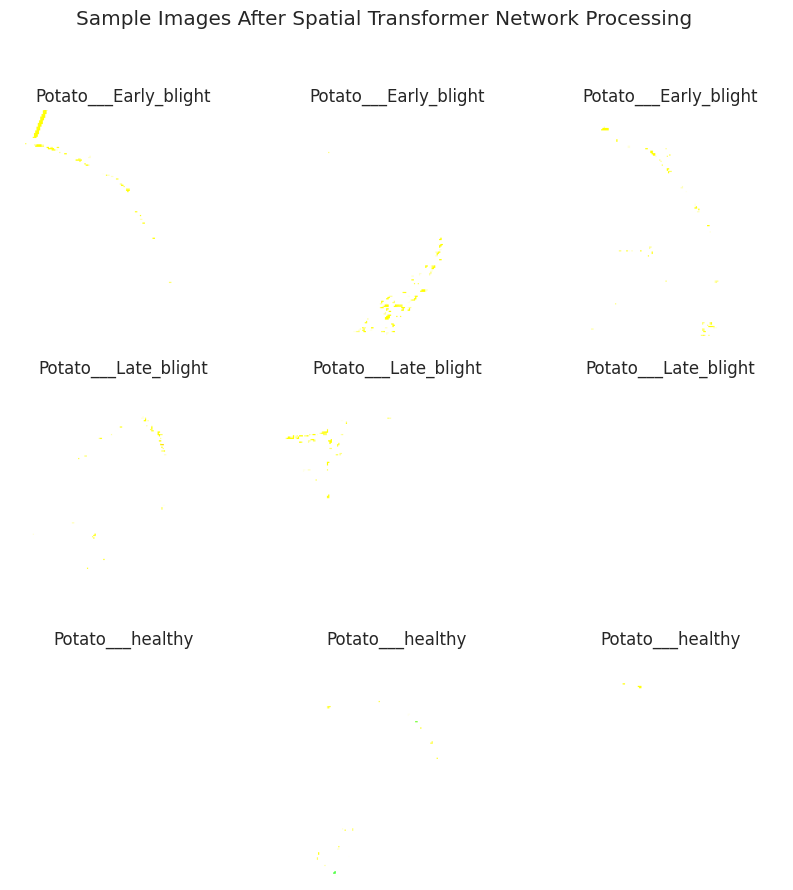

In [ ]:
# --- 4. Visualize the Effect of the STN ---
# This section visualizes how the STN processes the images before they reach the main CNN.
print("\nVisualizing random samples after STN processing...")

# Create a shuffled version of the training dataset for random sampling
shuffled_train_ds = train_ds.unbatch().shuffle(buffer_size=2000)

# Create a dictionary to hold the sample images and labels for each class
samples = {class_name: [] for class_name in class_names}
samples_needed = 3
sample_images_list = []
sample_labels_list = []

# Iterate through the shuffled dataset to find samples
for image, label in shuffled_train_ds:
    class_name = class_names[label]
    if len(samples[class_name]) < samples_needed:
        samples[class_name].append((image, label))
        sample_images_list.append(image)
        sample_labels_list.append(label)

    # Check if we have collected enough samples for all classes
    if all(len(s) == samples_needed for s in samples.values()):
        break

# Create a temporary model that only contains the STN to process the images
stn_model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    SpatialTransformer()
])

# Stack the collected images into a single batch
sample_images_batch = tf.stack(sample_images_list)
# Get the transformed images by passing the batch through the STN model
transformed_images = stn_model.predict(sample_images_batch)

# Plot the transformed samples
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # We multiply by 255 to bring the pixel values back to the displayable 0-255 range
    plt.imshow(transformed_images[i] * 255)
    plt.title(class_names[sample_labels_list[i]])
    plt.axis("off")
plt.suptitle("Sample Images After Spatial Transformer Network Processing")
plt.show()

# 2. Analyse input images of crops and soil

# 3. Give feedback from inputs